<a href="https://colab.research.google.com/github/ShreyBana/DCGAN/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython import display
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time

In [2]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
EPOCHS = 50
MEAN = 127.5
NOISE_SIZE = 100
SEED = tf.random.normal([16, NOISE_SIZE])

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = (train_images - MEAN) / MEAN
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

170500096/170498071 [==============================] - 2s 0us/step


In [4]:
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [5]:
def Generator():
    model = tf.keras.Sequential()

    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(NOISE_SIZE,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((4, 4, 256)))

    assert model.output_shape == (None, 4, 4, 256) # None is the batch size, assert for assurance of output shape
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    print('GENERATOR SUMMARY')
    model.summary()

    return model

def generate(model, noise, **kwargs):
    samples = model(noise, training=kwargs['training'])
    
    if kwargs['print'] == True:
        for i in range(samples.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(np.rint(samples[i]*MEAN + MEAN).astype(int))
            plt.axis('off')
        plt.show()

    return samples

def J_G(fake_output):
    return cross_entropy(tf.random.uniform(list(fake_output.shape), 0.7, 1.0), fake_output)

In [6]:
def Discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid')) 

    print('DISCRIMINATOR SUMMARY')
    model.summary()

    return model

def predict(model, images, **kwargs):
    predictions = model(images, training=kwargs['training'])

    if kwargs['print'] == True:
        print(predictions.numpy())

    return predictions

def J_D(real_output, fake_output):
    shape_f = list(fake_output.shape)
    shape_r = list(real_output.shape)

    real_loss = cross_entropy(tf.random.uniform(shape_r, 0.7, 0.1), real_output)
    fake_loss = cross_entropy(tf.random.uniform(shape_f, 0.0, 0.3), fake_output) # labels smoothing
    
    return real_loss + fake_loss

In [7]:
generator = Generator()
discriminator = Discriminator()

GENERATOR SUMMARY
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8,

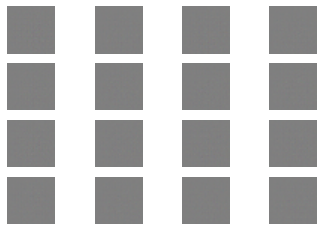

In [8]:
samples = generate(generator, SEED, print=True, training=False)

In [9]:
p = predict(discriminator, samples, print=True, training=False)

[[0.49989274]
 [0.49991453]
 [0.5001502 ]
 [0.50014055]
 [0.5001618 ]
 [0.50005263]
 [0.49993765]
 [0.49969488]
 [0.5000186 ]
 [0.49992156]
 [0.4999994 ]
 [0.4998212 ]
 [0.50001204]
 [0.5001684 ]
 [0.5001616 ]
 [0.49994725]]


In [10]:
@tf.function
def train_step(images):
    noise_fake = tf.random.normal([BATCH_SIZE, NOISE_SIZE])
    noise_real = tf.random.normal(list(images.shape), 0, 0.0001, tf.float64)
    images = tf.math.add(images, noise_real) # adding some noise to input images

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generate(generator, noise_fake, print=False, training=True)

        real_output = predict(discriminator, images, print=False, training=True)
        fake_output = predict(discriminator, generated, print=False, training=True)

        gen_loss = J_G(fake_output)
        disc_loss = J_D(real_output, fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [11]:
def train(dataset, epochs):
    gen_loss, disc_loss = [], []
    starting_time = time.time()
    for epoch in range(epochs):
        start = time.time()
        gl, dl = 0, 0

        for batch in dataset:
            temp1, temp2 = train_step(batch)
            gl += temp1
            dl += temp2
        
        gl = np.mean(gl)
        dl = np.mean(dl)

        display.clear_output(wait=True)
        generate(generator, SEED, print=True, training=False)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
        print('Generator loss: {}'.format(gl))
        print('Discriminator loss: {}'.format(dl))
           
        gen_loss.append(gl)
        disc_loss.append(dl)

    display.clear_output(wait=True)
    plt.plot(range(1, epochs + 1), gen_loss, 'g', label='Generator Loss')
    plt.plot(range(1, epochs + 1), disc_loss, 'b', label='Discriminator Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() 

    print('Total time: {} minutes'.format((time.time() - starting_time) / 60))
    print('Final Generator Loss: {}'.format(gen_loss[-1]))
    print('Final Discriminator Loss: {}'.format(disc_loss[-1]))

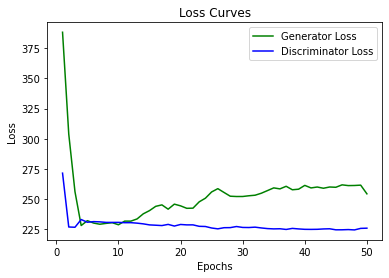

Total time: 20.188422230879464 minutes
Final Generator Loss: 254.36016845703125
Final Discriminator Loss: 225.8918914794922


In [12]:
train(train_dataset, EPOCHS)

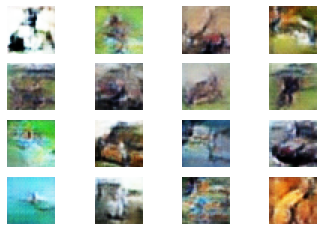

In [13]:
samples = generate(generator, SEED, print=True, training=False)